In [276]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain
import light_curve as lc
from astropy.table import MaskedColumn

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp


In [223]:
feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

In [295]:
ztf_id_ref = 'ZTF19aamsetj' #'ZTF20aalxlis' #'ZTF20aaelulu' #'ZTF22aaezyos'

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

In [296]:
np.mean(df_ref.ant_dec)


44.81281370769231

In [297]:
ref_info.lightcurve

,time,alert_id,ant_mjd,ant_survey,ant_ra,ant_dec,ant_passband,ant_mag,ant_magerr,ant_maglim,ant_mag_corrected,ant_magerr_corrected
0,2019-02-20 06:42:57.000949,ztf_upper_limit:ZTF19aamsetj-780279821115,58534.279826,2,NaN,NaN,g,NaN,NaN,19.282101,NaN,NaN
1,2019-02-20 08:35:40.997775,ztf_upper_limit:ZTF19aamsetj-780358111115,58534.358113,2,NaN,NaN,R,NaN,NaN,19.205999,NaN,NaN
2,2019-02-20 08:50:46.003206,ztf_upper_limit:ZTF19aamsetj-780368583815,58534.368588,2,NaN,NaN,R,NaN,NaN,18.914301,NaN,NaN
3,2019-02-24 05:05:31.997770,ztf_upper_limit:ZTF19aamsetj-784212171115,58538.212176,2,NaN,NaN,R,NaN,NaN,18.701799,NaN,NaN
4,2019-02-24 06:27:25.997751,ztf_upper_limit:ZTF19aamsetj-784269051115,58538.269051,2,NaN,NaN,g,NaN,NaN,19.500799,NaN,NaN
5,2019-02-27 06:17:41.000642,ztf_upper_limit:ZTF19aamsetj-787262281115,58541.262280,2,NaN,NaN,g,NaN,NaN,19.513500,NaN,NaN
6,2019-03-14 04:50:10.999668,ztf_upper_limit:ZTF19aamsetj-802201511115,58556.201516,2,NaN,NaN,R,NaN,NaN,19.607000,NaN,NaN
7,2019-03-16 04:41:27.000941,ztf_upper_limit:ZTF19aamsetj-804195453815,58558.195451,2,NaN,NaN,R,NaN,NaN,19.183399,NaN,NaN
8,2019-03-17 05:42:43.001280,ztf_candidate:805237991115015000,58559.237998,1,137.179139,44.812800,R,19.018499,0.114941,19.632299,NaN,NaN
9,2019-03-17 07:09:40.999692,ztf_candidate:805298391115015000,58559.298391,1,137.178974,44.812866,g,19.306700,0.241644,18.999201,NaN,NaN


In [298]:
df_ref

,ant_dec,ant_input_msg_time,ant_mag,ant_magerr,ant_maglim,ant_mjd,ant_passband,ant_ra,ant_survey,ant_time_received,...,ztf_sumrat,ztf_szmag1,ztf_szmag2,ztf_szmag3,ztf_tblid,ztf_tooflag,ztf_xpos,ztf_ypos,ztf_zpclrcov,ztf_zpmed
time,,,,,,,,,,,,,,,,,,,,,
2019-02-20 06:42:57.000949,NaN,1603331124,NaN,NaN,19.282101,58534.279826,g,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-02-20 08:35:40.997775,NaN,1603331124,NaN,NaN,19.205999,58534.358113,R,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-02-20 08:50:46.003206,NaN,1603331124,NaN,NaN,18.914301,58534.368588,R,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-02-24 05:05:31.997770,NaN,1603331124,NaN,NaN,18.701799,58538.212176,R,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-02-24 06:27:25.997751,NaN,1603331124,NaN,NaN,19.500799,58538.269051,g,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-02-27 06:17:41.000642,NaN,1603331124,NaN,NaN,19.513500,58541.262280,g,NaN,2,1603332043,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-03-14 04:50:10.999668,NaN,1603302993,NaN,NaN,19.607000,58556.201516,R,NaN,2,1603305155,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-03-16 04:41:27.000941,NaN,1603284928,NaN,NaN,19.183399,58558.195451,R,NaN,2,1603289993,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2019-03-17 05:42:43.001280,44.812800,1603284928,19.018499,0.114941,19.632299,58559.237998,R,137.179139,1,1603289993,...,0.985488,NaN,NaN,NaN,0,<NA>,2902.199951,225.908005,NaN,NaN


In [299]:
df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

<ErrorbarContainer object of 3 artists>

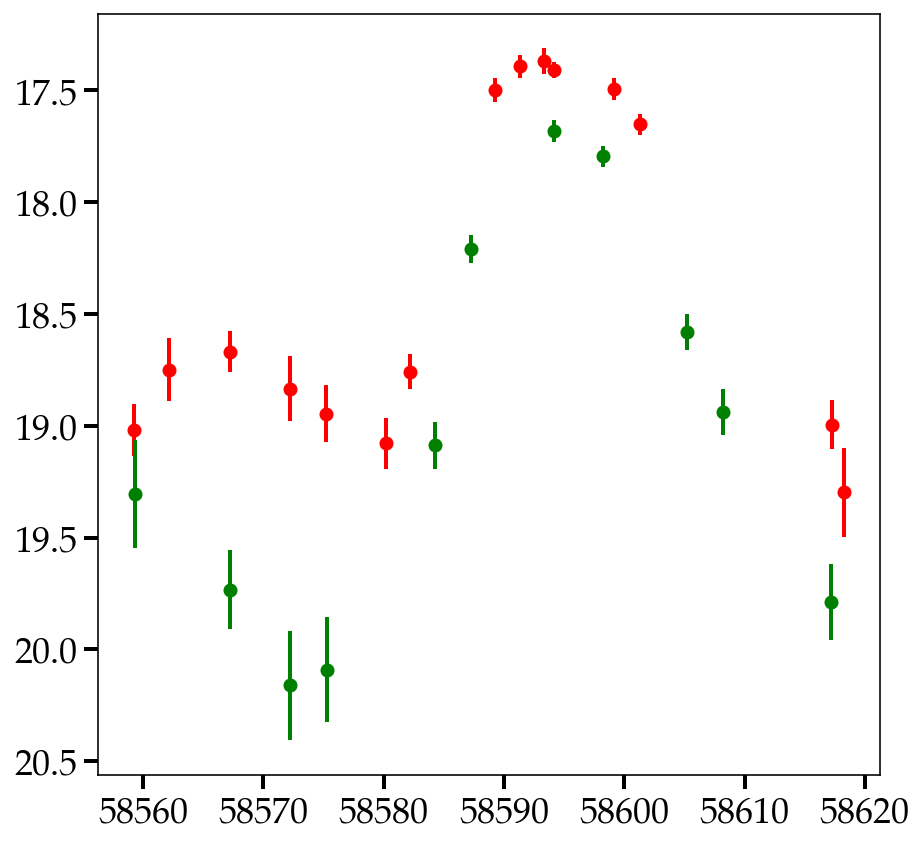

In [300]:
fig, ax = plt.subplots(figsize=(7,7))
plt.gca().invert_yaxis()

ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}')
ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# Extract LC features

In [301]:
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

min_obs_count=4
cls_name='BaseFeatures'

lightcurve = ref_info.lightcurve
feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)
lc_properties_d={}
for band, names in property_names.items():
    detections = get_detections(lightcurve, band)

    # Ensure locus has >3 obs for calculation
    if (len(detections) < min_obs_count):
        continue

    # if we have >= 4 observations, calculate features!
    t = detections['ant_mjd'].values
    m = detections['ant_mag'].values
    merr = detections['ant_magerr'].values
    flux = np.power(10.0, -0.4 * m)
    fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

    magn_features = MAGN_EXTRACTOR(
        t,
        m,
        merr,
        sorted=None,
        fill_value=None,
    )
    flux_features = FLUX_EXTRACTOR(
        t,
        flux,
        fluxerr,
        sorted=None,
        fill_value=None,
    )

    # After successfully calculating features, set locus properties and tag
    lc_properties_d["ztf_object_id"] = ztf_id_ref
    for name, value in zip(names, chain(magn_features, flux_features)):
        lc_properties_d[name] = value

In [302]:
lc_properties_d

{'ztf_object_id': 'ZTF19aamsetj',
 'feature_amplitude_magn_r': 0.9646358489990234,
 'feature_anderson_darling_normal_magn_r': 1.5319691546197145,
 'feature_beyond_1_std_magn_r': 0.4,
 'feature_beyond_2_std_magn_r': 0.0,
 'feature_cusum_magn_r': 0.46242827204483633,
 'feature_eta_e_magn_r': 0.3826078535419966,
 'feature_inter_percentile_range_2_magn_r': 1.9292716979980469,
 'feature_inter_percentile_range_10_magn_r': 1.6866989135742188,
 'feature_inter_percentile_range_25_magn_r': 1.4878497123718262,
 'feature_kurtosis_magn_r': -1.9224235445128406,
 'feature_linear_fit_slope_magn_r': -0.025633547406205964,
 'feature_linear_fit_slope_sigma_magn_r': 0.0015892904439459535,
 'feature_linear_fit_reduced_chi2_magn_r': 68.1013003530375,
 'feature_linear_trend_magn_r': -0.010106500591901095,
 'feature_linear_trend_sigma_magn_r': 0.011285770191790051,
 'feature_linear_trend_noise_magn_r': 0.7623042830044322,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0.3405176791454931,
 'feature_magnitu

In [303]:
feats = ['feature_amplitude_magn_r',
 'feature_anderson_darling_normal_magn_r',
 'feature_beyond_1_std_magn_r',
 'feature_beyond_2_std_magn_r',
 'feature_cusum_magn_r',
 'feature_inter_percentile_range_2_magn_r',
 'feature_inter_percentile_range_10_magn_r',
 'feature_inter_percentile_range_25_magn_r',
 'feature_kurtosis_magn_r',
 'feature_linear_fit_slope_magn_r',
 'feature_linear_fit_slope_sigma_magn_r',
 'feature_magnitude_percentage_ratio_40_5_magn_r',
 'feature_magnitude_percentage_ratio_20_5_magn_r',
 'feature_mean_magn_r',
 'feature_median_absolute_deviation_magn_r',
 'feature_percent_amplitude_magn_r',
 'feature_median_buffer_range_percentage_10_magn_r',
 'feature_median_buffer_range_percentage_20_magn_r',
 'feature_percent_difference_magnitude_percentile_5_magn_r',
 'feature_percent_difference_magnitude_percentile_10_magn_r',
 'feature_skew_magn_r',
 'feature_standard_deviation_magn_r',
 'feature_stetson_k_magn_r',
 'feature_weighted_mean_magn_r',
 'feature_anderson_darling_normal_flux_r',
 'feature_cusum_flux_r',
 'feature_excess_variance_flux_r',
 'feature_kurtosis_flux_r',
 'feature_mean_variance_flux_r',
 'feature_skew_flux_r',
 'feature_stetson_k_flux_r',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation_magn_g',
 'feature_median_buffer_range_percentage_10_magn_g',
 'feature_median_buffer_range_percentage_20_magn_g',
 'feature_percent_amplitude_magn_g',
 'feature_percent_difference_magnitude_percentile_5_magn_g',
 'feature_percent_difference_magnitude_percentile_10_magn_g',
 'feature_skew_magn_g',
 'feature_standard_deviation_magn_g',
 'feature_stetson_k_magn_g',
 'feature_weighted_mean_magn_g',
 'feature_anderson_darling_normal_flux_g',
 'feature_cusum_flux_g',
 'feature_excess_variance_flux_g',
 'feature_kurtosis_flux_g',
 'feature_mean_variance_flux_g',
 'feature_skew_flux_g',
 'feature_stetson_k_flux_g']

drop_feat_cols = ['feature_eta_e_magn_r',
                 'feature_linear_fit_reduced_chi2_magn_r', 
                 'feature_linear_trend_magn_r', # cadence removal
                 'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_linear_trend_noise_magn_r',  # cadence removal
                 'feature_maximum_slope_magn_r',
                 'feature_period_0_magn_r',  # should be negated
                 'feature_period_s_to_n_0_magn_r', # cadence removal
                 'feature_period_1_magn_r', 
                 'feature_period_s_to_n_1_magn_r', # cadence removal
                 'feature_period_2_magn_r', 
                 'feature_period_s_to_n_2_magn_r', # cadence removal
                 'feature_period_3_magn_r', 
                 'feature_period_s_to_n_3_magn_r', # cadence removal
                 'feature_period_4_magn_r', 
                 'feature_period_s_to_n_4_magn_r', # cadence removal
                 'feature_periodogram_amplitude_magn_r',
                 'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 'feature_chi2_magn_r',
                 'feature_eta_e_flux_r', 
                 'feature_chi2_flux_r', 
                 'feature_eta_e_magn_g',
                 'feature_linear_fit_reduced_chi2_magn_g', 
                 'feature_linear_trend_magn_g', # cadence removal
                 'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_linear_trend_noise_magn_g',
                 'feature_maximum_slope_magn_g', 
                 'feature_period_0_magn_g',  # should be negated
                 'feature_period_s_to_n_0_magn_g', # cadence removal
                 'feature_period_1_magn_g', 
                 'feature_period_s_to_n_1_magn_g', # cadence removal
                 'feature_period_2_magn_g', 
                 'feature_period_s_to_n_2_magn_g', # cadence removal
                 'feature_period_3_magn_g', 
                 'feature_period_s_to_n_3_magn_g', # cadence removal
                 'feature_period_4_magn_g', 
                 'feature_period_s_to_n_4_magn_g', # cadence removal
                 'feature_periodogram_amplitude_magn_g',
                 'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 'feature_chi2_magn_g',
                 'feature_eta_e_flux_g', 
                 'feature_chi2_flux_g',]

In [304]:
len(feats)

62

In [305]:
lc_properties_df = pd.DataFrame.from_dict(lc_properties_d, orient='index').T
#lc_properties_df.set_index('ztf_object_id')

lc_properties_df = lc_properties_df.drop(columns=drop_feat_cols)
lc_properties_df.set_index('ztf_object_id')

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_standard_deviation_magn_g,feature_stetson_k_magn_g,feature_weighted_mean_magn_g,feature_anderson_darling_normal_flux_g,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aamsetj,0.964636,1.531969,0.4,0.0,0.462428,1.929272,1.686699,1.48785,-1.922424,-0.025634,...,0.881982,0.928773,18.207668,0.861627,0.399976,0.664203,-0.018904,0.819551,1.121523,0.804094


# Get GHOST features

In [306]:
%%time

import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)

snCoord = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
with tempfile.TemporaryDirectory() as tmp:
    hosts = getTransientHosts(snName=[ztf_id_ref], snCoord=[snCoord], verbose=0, starcut='gentle', ascentMatch=False, savepath=tmp)
    # Save
    #hosts.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_hosts_start_idx-end_idx={start_idx}-{end_idx}.csv.gz', compression='gzip', index=False)
    #print("Saved!\n#############")

hosts

GHOST database already exists in the install path!
CPU times: user 1.51 s, sys: 255 ms, total: 1.77 s
Wall time: 1.89 s


,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,TransientDiscoveryDate,TransientDiscoveryMag,TransientRedshift,TransientDiscoveryYear,Transient AltName,host_logmass,host_logmass_min,host_logmass_max,Hubble Residual,TransientName
0,PSO J090842.632+444838.451,NaN,NaN,NaN,161771371776573444,1034262000068811,247926987230411,0,16458013175150,16177,...,2019-03-17 05:42:43,18.75,0.02751,2019.0,NaN,NaN,NaN,NaN,NaN,SN2019cad


array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']

In [308]:
# Define the label array
label_arr = np.array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
                     'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'])

# Define the spectroscopic class
spec_class = 'SN Ic'

# Find the index of the spectroscopic class in the label array
class_index = np.where(label_arr == spec_class)[0]

# Create a one-hot encoded array with all zeros
onehot_array = np.zeros(len(label_arr), dtype=float)

# Set the corresponding index to 1
onehot_array[class_index] = 1

# Reshape the array to have a shape of (1, num_classes)
onehot_array = onehot_array.reshape(1, -1)

# Print the one-hot encoded label
print(onehot_array)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [309]:
onehot_df = pd.DataFrame(np.array(onehot_array, dtype=float), columns=label_arr)
onehot_df

,None,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [310]:
hosts_df = hosts[feature_names_hostgal]

lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}.csv')
lc_and_hosts_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aamsetj,0.964636,1.531969,0.4,0.0,0.462428,1.929272,1.686699,1.48785,-1.922424,-0.025634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [311]:
lc_and_hosts_df.index[0]

'ZTF19aamsetj'